## Person Re-Identification
Dataset Used: P-DESTRE (http://p-destre.di.ubi.pt/)

Base Model: Inception V3 (https://arxiv.org/pdf/1512.00567v3.pdf)

In [1]:
# Import necessary library files
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
from dotenv import load_dotenv
import glob
import random
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Activation, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras import backend as K
tf.__version__

'2.8.0'

In [2]:
# Load env vars
load_dotenv('../.env')

True

In [3]:
# Nvidia GPU optimization
if os.getenv('CUDA_OPTIMIZE'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    tf.compat.v1.disable_eager_execution()


In [4]:
DATA_PATH_PREFIX = os.getenv('DATA_PATH_PREFIX') if os.getenv('DATA_PATH_PREFIX') else '../data/P-DESTRE/'
MODEL_PATH_PREFIX = os.getenv('MODEL_PATH_PREFIX') if os.getenv('MODEL_PATH_PREFIX') else '../models/'


In [5]:
# Set common params
im_height = 200
im_width = 200
num_channels = 3
num_p = 20
num_im = 100

In [6]:
def random_element(exclude, range_):
    return random.choice(list(set([x for x in range(0, range_)]) - set([exclude])))

# Generate pairs of images to train the siamese model with
def generate_pairs(vid):

    #     y1, y2, y3, y4
    #     s1, s2, s3, s4
    #     y1, yr 1
    #     y1, sr 0
    #     y2, yr 1
    #     y2, sr 0
    #     y3, yr
    #     y3, sr
    #     y4, yr 1
    #     y4, sr, 0

    #     2,4
    #     im[0][2] -> 0th person, 2nd image
    #     im[1][1] ->

    #     75*20*100*2

    images = np.zeros((num_p, num_im, im_height, im_width,
                      num_channels), dtype='uint8')
    path = DATA_PATH_PREFIX+'jpg_Extracted_PIDS/'+str(vid)+'/'
    folders = ([name for name in os.listdir(path)
               if os.path.isdir(os.path.join(path, name))])
    folders.sort()  # People
    folders = folders[1:1+num_p]
    for i, folder in enumerate(folders):
        temp_path = path+folder+'/'
        files = glob.glob(temp_path+'*', recursive=True)  # Image
        files = random.choices(files, k=num_im)
        for j, filename in enumerate(files):
            with Image.open(filename) as im:
                im = im.resize((im_height, im_width))
                images[i, j] = np.array(im)

    X = np.zeros((num_p*num_im*2, 2, im_height, im_width,
                 num_channels), dtype='uint8')  # (16 X 2 X 200 X 200 X 3)
    Y = np.zeros((num_p*num_im*2), dtype='uint8')
    v = 0
    for i in range(num_p):
        for j in range(num_im):
            p1 = np.concatenate(
                ([images[i][j]], [images[i][random_element(j, num_im)]]))
            p2 = np.concatenate(
                ([images[i][j]], [images[random_element(i, num_p)][random_element(j, num_im)]]))
            X[v] = p1
            Y[v] = 1.0
            v += 1
            X[v] = p2
            Y[v] = 0.0
            v += 1

    return X, Y


In [7]:
X, Y = generate_pairs('12-11-2019-4-1')
print(X.shape, Y.shape)

(4000, 2, 200, 200, 3) (4000,)


### Splitting the dataset

In [8]:
path = DATA_PATH_PREFIX+'jpg_Extracted_PIDS/'
folders = ([name for name in os.listdir(path)
           if os.path.isdir(os.path.join(path, name))])
print("Number of videos:", len(folders))
train_vids = [i for i in range(65)]
val_vids = [i for i in range(65, 70)]
test_vids = [i for i in range(70, 75)]


Number of videos: 75


In [9]:
# Training with a generator
def data_generator(vids, batch_size, eph):
    for _ in range(eph):
        #         steps = 260000//batch_size
        # our steps will be 2600
        for i in vids:
            f = folders[i]
            X_batch, Y_batch = generate_pairs(f)  # 4000
            for i in range(0, num_p*num_im*2, batch_size):
                yield [X_batch[i:i+batch_size, 0], X_batch[i:i+batch_size, 1]], Y_batch[i:i+batch_size]


### Building the model

In [10]:
base_model = tf.keras.applications.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(im_height, im_width, num_channels),
    include_top=False,
)
# Freeze the base_model
base_model.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
def l1_distance(inputs):
    input1, input2 = inputs
    output = K.abs(input1 - input2)
    return output

def l1_distance_output_shape(shapes):
    shape1, shape2 = shapes
    assert shape1 == shape2
    return (1,)

In [12]:
def siamese_model():
    input1 = Input(shape=(im_height, im_width, num_channels,))
    input2 = Input(shape=(im_height, im_width, num_channels,))
    processed_input1 = tf.keras.applications.inception_v3.preprocess_input(input1)
    processed_input2 = tf.keras.applications.inception_v3.preprocess_input(input2)
    feature_vec1 = base_model(processed_input1)
    feature_vec2 = base_model(processed_input2)
    pool1 = GlobalAveragePooling2D()(feature_vec1) # 6x6x2048 -> 2048
    pool2 = GlobalAveragePooling2D()(feature_vec2)
    distance = Lambda(l1_distance, output_shape=l1_distance_output_shape)([pool1, pool2])
    d1 = Dense(256)(distance)
    d2 = Dense(1)(d1)
    output = Activation('sigmoid')(d2)
    return Model(inputs=[input1, input2], outputs=output)

In [13]:
def plot_history(histories):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.ravel()

    i = 0
    for phase in histories.keys():
        # summarize history for accuracy
        axs[i].plot(histories[phase]['binary_accuracy'])
        axs[i].plot(histories[phase]['val_binary_accuracy'])
        axs[i].set(title=f'model accuracy ({phase})',
                   ylabel='accuracy',
                   xlabel='epoch',
                   ylim=[0, 1],
                   xticks=histories[phase]['epoch'],
                   xticklabels=[x + 1 for x in histories[phase]['epoch']])
        axs[i].legend(['training', 'validation'], loc='upper left')

        i += 1

        # summarize history for loss
        axs[i].plot(histories[phase]['loss'])
        axs[i].plot(histories[phase]['val_loss'])
        axs[i].set(title=f'model loss ({phase})',
                   ylabel='loss',
                   xlabel='epoch',
                   xticks=histories[phase]['epoch'],
                   xticklabels=[x + 1 for x in histories[phase]['epoch']])
        axs[i].legend(['training', 'validation'], loc='upper left')

        i += 1

    plt.show()


In [14]:
visualize = lambda: display(Image.open('../assets/architecture.png'))


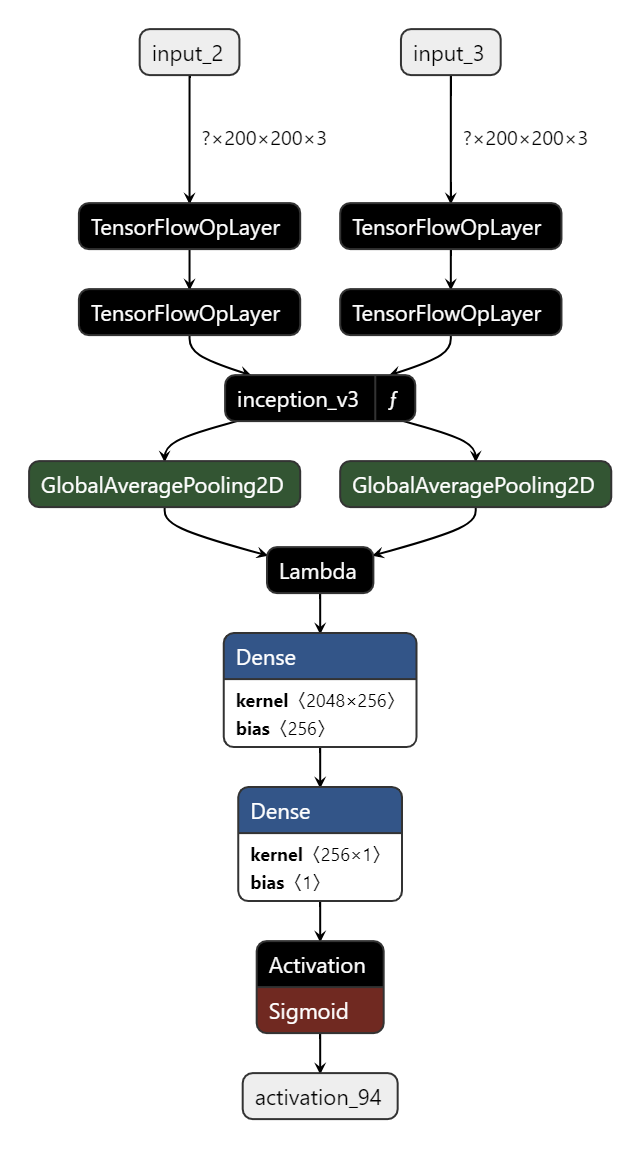

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf_op_layer_truediv (TensorFlo  [(None, 200, 200, 3  0          ['input_2[0][0]']                
 wOpLayer)                      )]                                                            

In [15]:
model = siamese_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
visualize()
model.summary()

In [16]:
history = {}

# parse history object to get a dict that can be pickled
parse_history = lambda history: {k: v for k, v in history.history.items()} | {'epoch': history.epoch}


### Training

In [17]:
bs = int(os.getenv('BATCH_SIZE_TRAIN')) if os.getenv('BATCH_SIZE_TRAIN') else 100
eph = 15
history['training'] = parse_history(model.fit(data_generator(train_vids, bs, eph),
          validation_data=data_generator(val_vids, bs, eph),
          epochs=eph, steps_per_epoch=2600,
          validation_steps=200))


Epoch 1/15
2600/2600 [==============================] - ETA: 0s - batch: 1299.5000 - size: 1.0000 - loss: 0.5516 - binary_accuracy: 0.8023

c:\programdata\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2600/2600 [==============================] - 99s 35ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.5516 - binary_accuracy: 0.8023 - val_loss: 1.8914 - val_binary_accuracy: 0.5100
Epoch 2/15
2600/2600 [==============================] - 98s 38ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.4812 - binary_accuracy: 0.7804 - val_loss: 1.0353 - val_binary_accuracy: 0.4650
Epoch 3/15
2600/2600 [==============================] - 97s 37ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.5211 - binary_accuracy: 0.7650 - val_loss: 1.1256 - val_binary_accuracy: 0.5300
Epoch 4/15
2600/2600 [==============================] - 101s 39ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.5511 - binary_accuracy: 0.7519 - val_loss: 1.3532 - val_binary_accuracy: 0.5000
Epoch 5/15
2600/2600 [==============================] - 101s 39ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.5029 - binary_accuracy: 0.7773 - val_loss: 0.6631 - val_binary_accuracy: 0.6500
Epoch 6/15
2600/2600 [=================

### Evaluation

In [18]:
loss, accuracy = model.evaluate(data_generator(test_vids, bs, eph), steps=200)
print("Test set accuracy of the model is: ", accuracy*100, "%")


Test set accuracy of the model is:  57.499998807907104 %


In [20]:
model.save_weights(MODEL_PATH_PREFIX + 'siamese_weights.h5')
with open(MODEL_PATH_PREFIX + 'history.pkl', 'wb') as f:
    pickle.dump(history, f)


In [23]:
# Restart the kernel and run this before fine-tuning to avoid VRAM exhaustion

model.load_weights(MODEL_PATH_PREFIX + 'siamese_weights.h5')
with open(MODEL_PATH_PREFIX + 'history.pkl', 'rb') as f:
    history = pickle.load(f)


### Fine-tuning

In [21]:
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
    )
bs = int(os.getenv('BATCH_SIZE_TUNE')) if os.getenv('BATCH_SIZE_TUNE') else 10
eph = 15
history['fine-tuning'] = parse_history(model.fit(data_generator(train_vids, bs, eph),
                            validation_data=data_generator(val_vids, bs, eph),
                            epochs=eph, steps_per_epoch=2600,
                            validation_steps=200))


Epoch 1/15
2600/2600 [==============================] - 228s 84ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.1817 - binary_accuracy: 0.9354 - val_loss: 0.5966 - val_binary_accuracy: 0.6900
Epoch 2/15
2600/2600 [==============================] - 222s 85ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.2011 - binary_accuracy: 0.9204 - val_loss: 0.7388 - val_binary_accuracy: 0.6450
Epoch 3/15
2600/2600 [==============================] - 213s 82ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.2546 - binary_accuracy: 0.9085 - val_loss: 1.1042 - val_binary_accuracy: 0.6200
Epoch 4/15
2600/2600 [==============================] - 247s 95ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.1790 - binary_accuracy: 0.9331 - val_loss: 0.7741 - val_binary_accuracy: 0.6850
Epoch 5/15
2600/2600 [==============================] - 252s 97ms/step - batch: 1299.5000 - size: 1.0000 - loss: 0.1295 - binary_accuracy: 0.9550 - val_loss: 0.7128 - val_binary_accuracy: 0.6450
Epoch 6/15
2600/2600 [===

### Evaluation

In [22]:
loss, accuracy = model.evaluate(data_generator(test_vids, bs, eph), steps=200)
print("Test set accuracy of the model after fine-tuning is: ", accuracy*100, "%")


Test set accuracy of the model after fine-tuning is:  72.50000238418579 %


In [23]:
model.save(MODEL_PATH_PREFIX + 'siamese.h5')
with open(MODEL_PATH_PREFIX + 'history.pkl', 'wb') as f:
    pickle.dump(history, f)


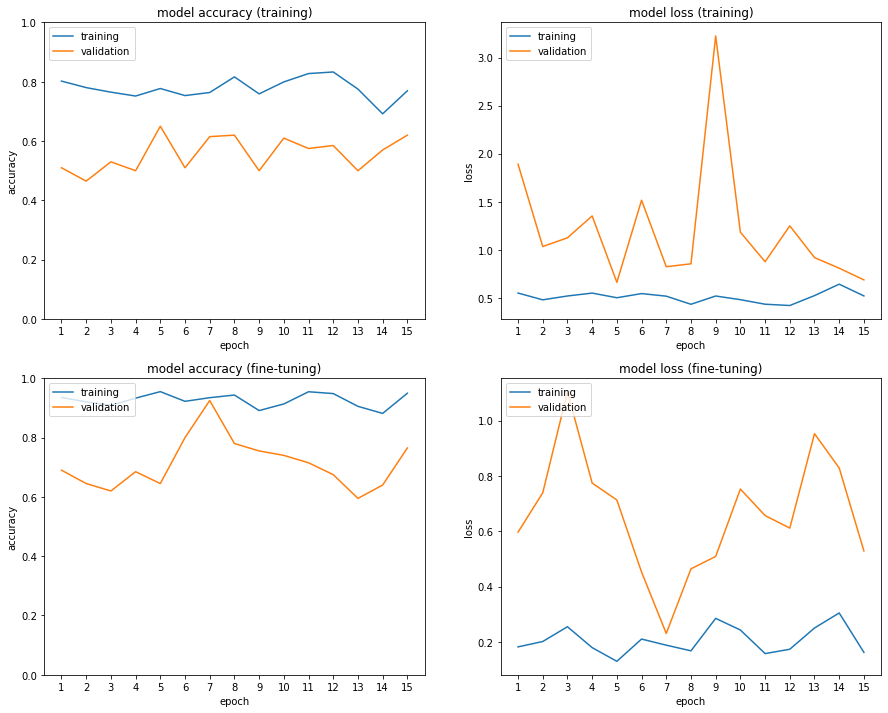

In [24]:
plot_history(history)

References:
    https://github.com/aup8497/Person-Re-identification-using-Siamese-networks/blob/master/Code/siamese_model.py

In [ ]:
from sys import platform
# If the platform is macOS
if platform == 'darwin':
    ### code to enable GPU acceleration on M1 Mac
    from tensorflow.python.compiler.mlcompute import mlcompute
    tf.compat.v1.disable_eager_execution()
    mlcompute.set_mlc_device(device_name='gpu')
    print("is_apple_mlc_enabled %s" % mlcompute.is_apple_mlc_enabled())
    print("is_tf_compiled_with_apple_mlc %s" % mlcompute.is_tf_compiled_with_apple_mlc())
print(f"eagerly? {tf.executing_eagerly()}")
print(tf.config.list_logical_devices())


eagerly? True
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
